### DataSet
https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database/data

In [28]:
!pip install keras_tqdm

Defaulting to user installation because normal site-packages is not writeable


In [29]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.utils import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [30]:
import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [31]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1274526117480604738
xla_global_id: -1
]
Device mapping: no known devices.


In [32]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [33]:
with open(r'C:\Users\Dell\Desktop\hwr\words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents][18:]

In [34]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [35]:
images = []
labels = []

RECORDS_COUNT = 10000

In [36]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [37]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

## Generate train & validation set

In [38]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'C:/Users/Dell/Desktop/hwr/iam_words/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [39]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [40]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

## Converts to Numpy array

In [41]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [42]:
train_images.shape

(7850, 32, 128, 1)

In [43]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
#squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
#squeezed = Lambda(lambda x: tf.squeeze(x, axis=1), output_shape=(31, 512))(conv_7)
squeezed = Lambda(lambda x: tf.squeeze(x, axis=1))(conv_7)
reshaped = tf.keras.layers.Reshape((31, 512))(squeezed)

 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [44]:
act_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 128, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 128, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 32, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 32, 256)          │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 32, 256)          │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 32, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 32, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 32, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 4, 32, 512)          │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 32, 512)          │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 32, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 1, 31, 512)          │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 31, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 31, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 31, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 31, 79)              │          40,527 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,743,247 (33.35 MB)

 Trainable params: 8,741,199 (33.35 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [45]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')



def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [46]:
model.compile(optimizer='adam', loss=lambda y_true, y_pred: y_pred)


In [47]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 32, 128, 1)        │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 128, 64)       │             640 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 16, 64, 64)        │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 16, 64, 128)       │          73,856 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 8, 32, 128)        │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 8, 32, 256)        │         295,168 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 8, 32, 256)        │         590,080 │ conv2d_9[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 4, 32, 256)        │               0 │ conv2d_10[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 4, 32, 512)        │       1,180,160 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 4, 32, 512)        │           2,048 │ conv2d_11[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_12 (Conv2D)            │ (None, 4, 32, 512)        │       2,359,808 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 4, 32, 512)        │           2,048 │ conv2d_12[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 2, 32, 512)        │               0 │ batch_normalization_3[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_13 (Conv2D)            │ (None, 1, 31, 512)        │       1,049,088 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 8,743,247 (33.35 MB)

 Trainable params: 8,741,199 (33.35 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [48]:
batch_size = 32
epochs = 20
e = str(epochs)
optimizer_name = 'adam'

In [49]:
# Define the filepath for saving the model with the .keras extension
filepath = "{}o-{}r-{}e-{}t-{}v.keras".format(optimizer_name,
                                              str(RECORDS_COUNT),
                                              str(epochs),
                                              str(train_images.shape[0]),
                                              str(valid_images.shape[0]))

# Set up the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

# Now you can fit the model with the callbacks
# act_model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), epochs=epochs, callbacks=callbacks_list)

In [50]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'

In [51]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=10, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,callbacks=callbacks_list)

Epoch 1/10

Epoch 1: val_loss improved from inf to 14.93551, saving model to adamo-10000r-20e-7850t-876v.keras


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: model.compile(optimizer='adam', loss=lambda y_true, y_pred: y_pred)

  return {key: serialize_keras_object(value) for key, value in obj.items()}


246/246 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - loss: 19.2948 - val_loss: 14.9355
Epoch 2/10

Epoch 2: val_loss improved from 14.93551 to 13.69280, saving model to adamo-10000r-20e-7850t-876v.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - loss: 13.3563 - val_loss: 13.6928
Epoch 3/10

Epoch 3: val_loss improved from 13.69280 to 11.63919, saving model to adamo-10000r-20e-7850t-876v.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - loss: 11.6587 - val_loss: 11.6392
Epoch 4/10

Epoch 4: val_loss improved from 11.63919 to 9.80194, saving model to adamo-10000r-20e-7850t-876v.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - loss: 10.4678 - val_loss: 9.8019
Epoch 5/10

Epoch 5: val_loss improved from 9.80194 to 9.44543, saving model to adamo-10000r-20e-7850t-876v.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - loss: 8.8869 - val_loss: 9.4454
Epoch 6/10

Epoch 6: val_loss improved from 9.44543 to 7.25297, saving model to adamo-10000r-20e-7850t-876v.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/s

In [52]:
from tensorflow.keras.models import load_model, save_model

model.save('Words_model1.h5')


## Training Accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Original text: brought
Predicted text: brought


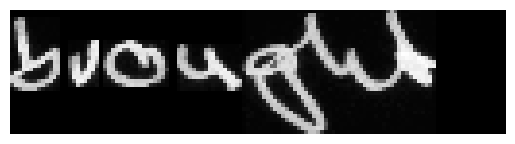

Original text: life
Predicted text: life


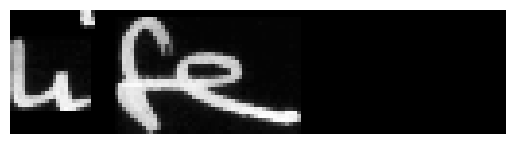

Original text: peers
Predicted text: peers


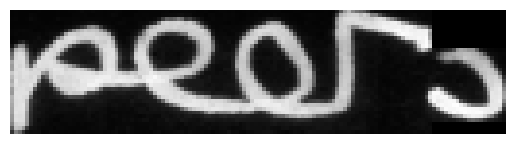

Original text: into
Predicted text: into


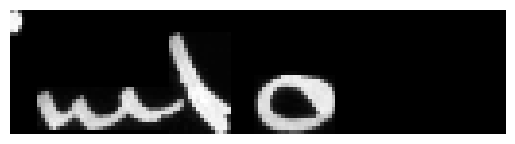

Original text: existence
Predicted text: existence


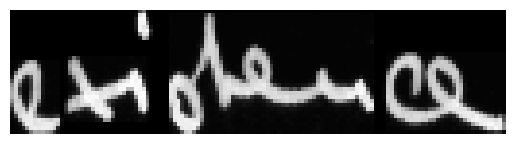

Original text: ,
Predicted text: ,


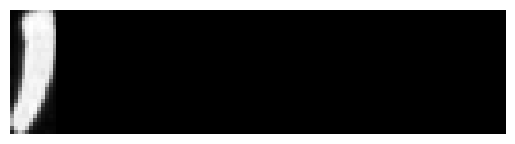

Original text: they
Predicted text: they


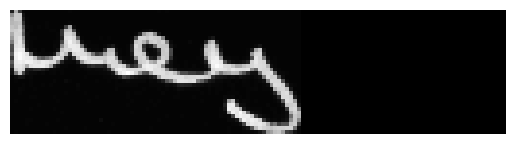

Original text: not
Predicted text: not


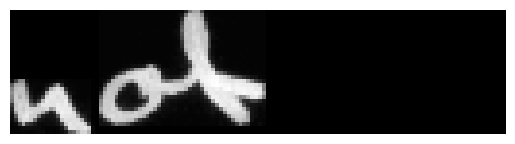

Original text: now
Predicted text: mores


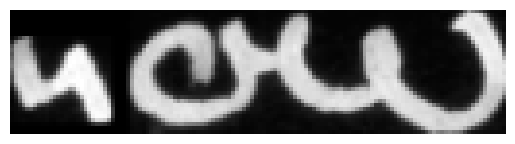

Original text: put
Predicted text: puutr


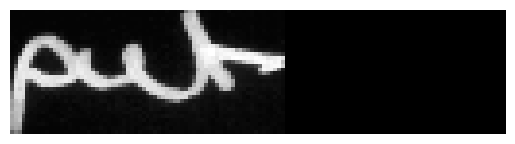


Overall accuracy for the subset: 93.02%


In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set the starting index (can be adjusted as needed)
start_index = 170
end_index = start_index + 10  # Number of samples to process

# Generate predictions for a subset of training images
subset_images = train_images[start_index:end_index]
prediction = act_model.predict(subset_images)

# Use TensorFlow's ctc_decode for decoding
decoded, _ = tf.keras.backend.ctc_decode(
    y_pred=prediction,
    input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
    greedy=True
)

# Convert the decoded output to a NumPy array
decoded_sequences = tf.keras.backend.get_value(decoded[0])

# Track total correct characters and total characters across the subset
total_correct_characters = 0
total_characters = 0

# Display the results
for i, sequence in enumerate(decoded_sequences):
    original_text = train_original_text[start_index + i]
    predicted_text = ''.join(
        char_list[int(p)] for p in sequence if 0 <= int(p) < len(char_list) and int(p) != -1  # Convert numbers to characters, skipping padding
    )

    # Count correct characters
    correct_characters = sum(
        1 for orig, pred in zip(original_text, predicted_text) if orig == pred
    )
    
    total_correct_characters += correct_characters
    total_characters += len(original_text)  # Add the number of characters in the original text (ignoring padding)

    # Print results
    print(f"Original text: {original_text}")
    print(f"Predicted text: {predicted_text}")
    
    # Show the corresponding image
    plt.imshow(subset_images[i].reshape(32, 128), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

# Calculate and display overall accuracy (correct characters / total characters)
if total_characters > 0:
    accuracy_percentage = (total_correct_characters / total_characters) * 100
else:
    accuracy_percentage = 0

print(f"\nOverall accuracy for the subset: {accuracy_percentage:.2f}%")
